In [2]:
# -*- coding: utf-8 -*-


import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:

data = pd.read_csv('AAPL_historical_stock_prices.csv')
dataset_train=data.iloc[0:930,1:2]
dataset_test=data.iloc[930:,1:2]
training_set = data.iloc[0:930, 3:4].values
testing_set=data.iloc[930:,3:4].values

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Change
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,-0.972204
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800,-0.972204
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200,0.796825
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000,-0.470305
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750237,132079200,1.608629


         Date       Open       High        Low      Close
0  2020-01-02  74.059998  75.150002  73.797501  75.087502
1  2020-01-03  74.287498  75.144997  74.125000  74.357498
2  2020-01-06  73.447502  74.989998  73.187500  74.949997
3  2020-01-07  74.959999  75.224998  74.370003  74.597504
4  2020-01-08  74.290001  76.110001  74.290001  75.797501


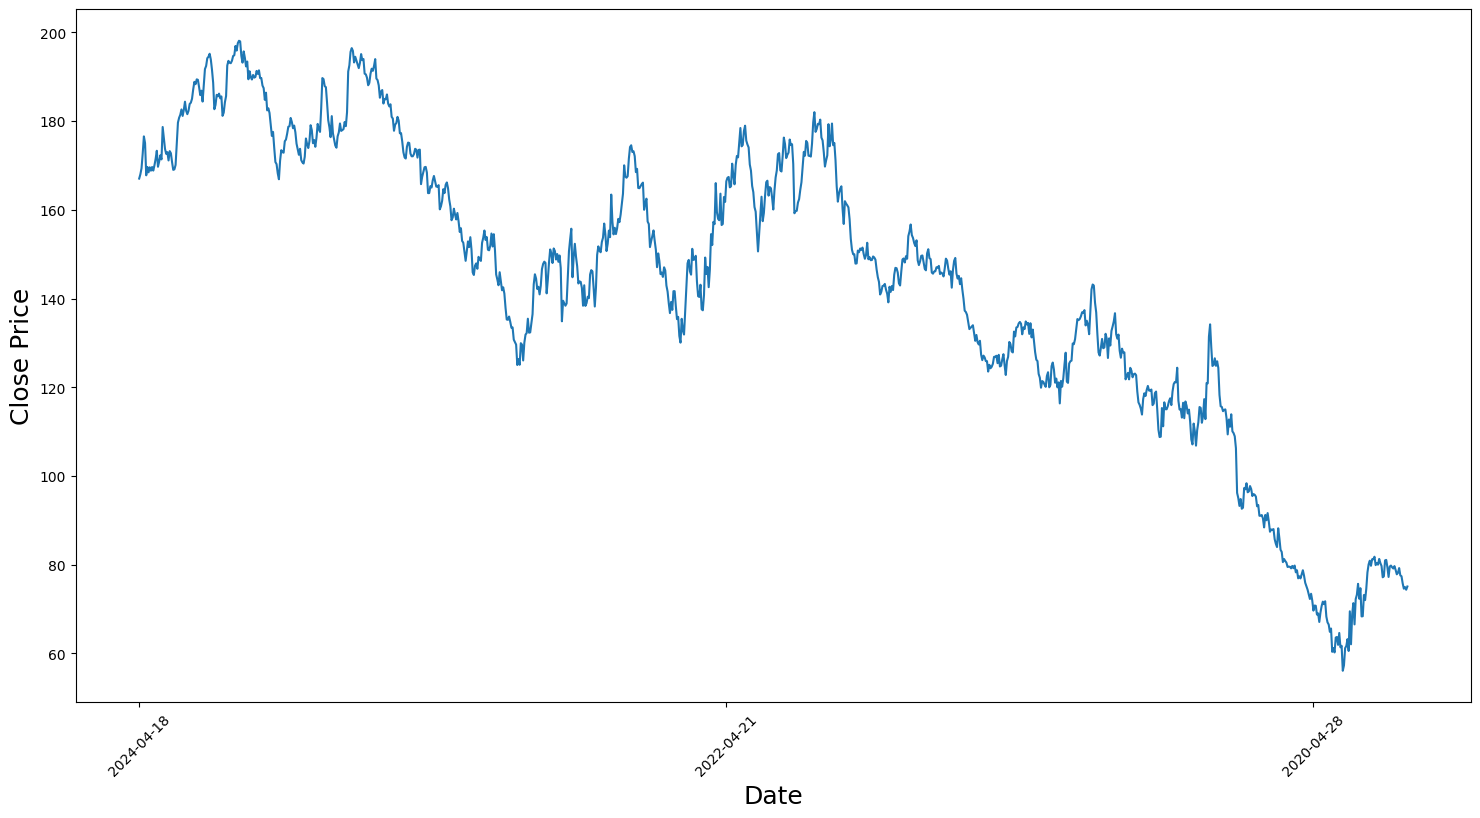

In [4]:
data.drop('Adj Close', axis=1, inplace=True)
data.drop('Volume', axis=1, inplace=True)
data.drop('Change', axis=1, inplace=True)
print(data.head())
data.to_csv('tata_preprocessed.csv',index= False)
data = data.iloc[::-1]

plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),(data['Close']))
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()


In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
len(training_set_scaled)
X_train = []
y_train = []
for i in range(10,930):
    X_train.append(training_set_scaled[i-10:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 75, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='relu'))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(SimpleRNN(units = 75))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.summary()

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 200, batch_size = 64)

real_stock_price = testing_set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 10:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 75)            23100     
                                                                 
 dropout_4 (Dropout)         (None, 10, 75)            0         
                                                                 
 lstm_3 (LSTM)               (None, 10, 50)            25200     
                                                                 
 dropout_5 (Dropout)         (None, 10, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 10, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 10, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 75)               

In [7]:
# Prepare input data for the next week's prediction
next_week_inputs = inputs[-10:]  # Select the last 10 data points
next_week_predictions = []  # Store predictions for the next week

# Number of days to predict (assuming a 5-day trading week)
days_to_predict = 5

for _ in range(days_to_predict):
    # Reshape input data
    next_week_inputs = np.reshape(next_week_inputs, (1, next_week_inputs.shape[0], 1))

    # Predict the next day's stock price
    next_day_prediction = regressor.predict(next_week_inputs)

    # Store the prediction
    next_week_predictions.append(next_day_prediction[0, 0])

    # Update input data for the next prediction
    next_week_inputs = np.append(next_week_inputs[0][1:], next_day_prediction)

# Inverse transform the predictions
next_week_predictions = sc.inverse_transform(np.array(next_week_predictions).reshape(-1, 1))


1/1 [==============================] - 0s 36ms/step
